### MNIST LeNet

In this notebook we are going to create an image classification model using the [LeNet-5](http://yann.lecun.com/exdb/lenet/) model achitecture in MNIST digits classification.

<p align="center">
<img src="https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1"/>
</p>

### Data processing
We will import necessary packages and prepare our mnist digit classifier using the `LeNet-5` achitecture

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data
import random, time, os, copy

import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition, manifold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from prettytable import PrettyTable

torch.__version__

'1.10.0+cu111'

### Setting seeds

In [2]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Mean and Standard Deviation
In the following code cell we are going to calculate the mean and standard deviation from the train data. We are ging to use the mean and standard deviation for normalizing the images during preprocessing.


In [5]:
train_data = datasets.MNIST(
    '.', train=True, download=True
)

mean = train_data.data.float().mean() / 255.
std = train_data.data.float().std() / 255.

def tabulate(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

tabulate([
    "Measure of Central Tendecy", "Value"
],[
   ("mean", mean.item()),
   ("standard dev (std)", std.item())
], "THE MEAN AND STANDARD DEVIATION OF THE DATA")

+--------------------------------------------------+
|   THE MEAN AND STANDARD DEVIATION OF THE DATA    |
+----------------------------+---------------------+
| Measure of Central Tendecy |               Value |
+----------------------------+---------------------+
| mean                       | 0.13066047430038452 |
| standard dev (std)         | 0.30810779333114624 |
+----------------------------+---------------------+


### Data transformation.

We are going to transform our dataset, In the following code cell we are going to define our image tranformation for both the train and test set. The test transformation will be used as validation transformation.


In [6]:
train_transforms = transforms.Compose([
        transforms.RandomRotation(5, fill=(0, )),
        transforms.RandomCrop(28, padding=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std], inplace=False)
])
test_transforms = transforms.Compose([
         transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std], inplace=False)  
])

### Loading the data

We are then going to load the data and apply transformation to each set in the following code cell:

In [7]:
train_data = datasets.MNIST('.',
                            train= True,
                            download=True,
                            transform=train_transforms
                            )
test_data = datasets.MNIST('.', 
                           train=False,
                           download=True,
                           transform=test_transforms
                           )

### Creating a `validation` set from the train set.
We will create a validation set from our train set as usual and then overide the train transforms, and make sure that we use a `deepcopy` when taking example from the train data so that when overriding the transformations we dont overide train transformations as well.

In [8]:
n_valid = int(len(train_data) * 0.1)
n_train = len(train_data) - n_valid
train_data, valid_data = data.random_split(train_data, [n_train, n_valid])

### Checking how many examples for each set.

In [9]:
title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = ("training", len(train_data)), ("testing", len(test_data)), ("validation", len(valid_data))
tabulate(columns, data_rows, title)

+--------------------+
| DATASETS EXAMPLES  |
+------------+-------+
| SET        | TOTAL |
+------------+-------+
| training   | 54000 |
| testing    | 10000 |
| validation |  6000 |
+------------+-------+


In [10]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

### Creating iterators
Again we are going to use the `DataLoader` to create iterators for 

In [11]:
BATCH_SIZE = 64
train_iterator = data.DataLoader(
    train_data, shuffle=True,
    batch_size = BATCH_SIZE
)
test_iterator = data.DataLoader(
    test_data,
    batch_size = BATCH_SIZE
)
valid_iterator = data.DataLoader(
    valid_data,
    batch_size = BATCH_SIZE
)



### LeNet Model

Now we've gone through all of the concepts we can implement our model.
<p align="center"><img src="https://camo.githubusercontent.com/0f2b54062770fd0f7c65c20be680b73016168e05/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d696d6167652d636c617373696669636174696f6e2f626c6f622f6d61737465722f6173736574732f6c656e6574352e706e673f7261773d31"/></p>

Our actual implementation is going to slightly differ from the actual `LeNet` architecture as it was built to handle `32x32` images, whereas the MNIST dataset consists of `28x28` images. We're also not going to use the Gaussian connections at the end, instead we'll just use a standard linear layer.

The first layer in our model is convolutional layer with 6 filters (PyTorch calls them out_channels) and a kernel size of 5. This turns our ``[1, 28, 28]`` image into ``[6, 24, 24]``. 
```
width = width - filter_size(out_channels) + 1
height = height - filter_size(out_channels)  + 1
```
We then downsample our image with a max pooling layer that has a filter size of 2 to get a `[6, 12, 12]` image. This is then passed through an activation function, ReLU in this case, which is applied elementwise and does not change the of the image.

Afterwards, we pass the image to the second convolutional layer with 16 filters that are `5x5x6`, a height and width of `5` and a depth of `6` as our previous convolutional layer had 6 filters. This gives us an image size of `[16, 8, 8]` which we then max pool to half the heigth and width to `[16, 4, 4]` and then pass through another `ReLU` function.

We then flatten our `[16, 4, 4]` image to `[256]` and pass this through three linear layers. Each of the linear layers are followed by another ReLU, except for the last.

We return the results from the final linear layer as well as from the flattened result of the second convolutional layer, which we can plot in lower dimensions later.

**Note that you should always apply your activation function after the pooling layer**. You will get the exact same results if you apply the activation function before, however this means you will be applying your activation function to a larger number of inputs, increasing the computation required. Using the activation function after the image has been reduced in size means it will be applied to less inputs and thus use less computation.



In [12]:
class LeNet(nn.Module):
  def __init__(self, output_dim):
    super(LeNet, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size =5),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size =5),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU()
    )
    self.classifier = nn.Sequential(
        nn.Linear(16 * 4 * 4, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, output_dim)
    )
  def forward(self, x):
    x = self.features(x) # x = [batch size, 16, 4, 4]
    x = x.view(x.shape[0], -1) # x = [batch size, 16*4*4 = 256]
    x = self.classifier(x) # x = [batch size, output dim]
    return x

### Device

Get gpu accelleration if possible.

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
device

device(type='cuda')

In [14]:
OUTPUT_DIM = 10

mnist_lenet = LeNet(OUTPUT_DIM).to(device)
mnist_lenet

LeNet(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

### Conting parameters of the model.

In [15]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  tabulate(["","Parameters"], 
           [["total parameters", f'{total_params:,}'],
            ["trainable parameters", f'{trainable_params:,}']],
           "MODEL PARAMETERS"
           )
  
count_params(model=mnist_lenet)

+-----------------------------------+
|          MODEL PARAMETERS         |
+----------------------+------------+
|                      | Parameters |
+----------------------+------------+
| total parameters     |     44,426 |
| trainable parameters |     44,426 |
+----------------------+------------+


### Optimizer and loss function.

In [16]:
optimizer = torch.optim.Adam(mnist_lenet.parameters())
criterion = nn.CrossEntropyLoss().to(device)

### Categorical accuracy function.

In [17]:
def categorical_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/ y.shape[0]
  return acc

### Training and Evaluation function.

In [18]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device)
    # Zero the gradients
    optimizer.zero_grad()
    y_pred = model(x)
    # Calculate the loss and accuracy
    loss = criterion(y_pred, y)
    acc = categorical_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()

    epoch_loss +=loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred = model(x)
      loss = criterion(y_pred, y)
      acc = categorical_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

### Visualize training

In [19]:
def hms_string(sec_elapsed):
  h = int(sec_elapsed / (60 * 60))
  m = int((sec_elapsed % (60 * 60)) / 60)
  s = sec_elapsed % 60
  return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [20]:
def tabulate_training(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  table.align[column_names[2]] = 'r'
  table.align[column_names[3]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

In [22]:
EPOCHS = 20
MODEL_NAME = "mnist-classifier.pt"
best_valid_loss = float('inf')
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]

for epoch in range(EPOCHS):
  start = time.time()

  train_loss, train_acc = train(mnist_lenet, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(mnist_lenet, valid_iterator, criterion, device)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(mnist_lenet.state_dict(), MODEL_NAME)
  end = time.time()

  data_rows = [
      ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
      ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
  ]
  title = f"EPOCH {epoch+1:02}/{EPOCHS}"
  tabulate_training(column_names, data_rows, title)

+--------------------------------------------+
|                EPOCH 01/20                 |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.177 |   94.47% | 0:00:33.85 |
| Validation | 0.076 |   97.70% |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|                EPOCH 02/20                 |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.104 |   96.74% | 0:00:27.91 |
| Validation | 0.066 |   98.14% |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|                EPOCH 03/20                 |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      

### Evaluating the best model.

In [23]:
mnist_lenet.load_state_dict(torch.load(MODEL_NAME))

test_loss, test_acc = evaluate(mnist_lenet, test_iterator, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_training(column_names, data_rows, title)

+--------------------------------------+
|       Model Evaluation Summary       |
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.021 |   99.31% |            |
+------+-------+----------+------------+


### Making predictions and plotting them.

In [26]:
def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs

In [27]:
images, labels, probs = get_predictions(mnist_lenet, test_iterator, device)

In [28]:
pred_labels = torch.argmax(probs, 1)
pred_labels

tensor([7, 2, 1,  ..., 4, 5, 6])

In [29]:
def plot_predictions_images(images, labels_true,
                            labels_pred, cols=5, rows = 3):
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image, label_true, label_pred) in enumerate(zip(images, labels_true, labels_pred)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image[0, :, :], cmap="gray")
  
        plt.title(label_pred.item(), color ='g' if label_true == label_pred else 'r', fontsize=16 )

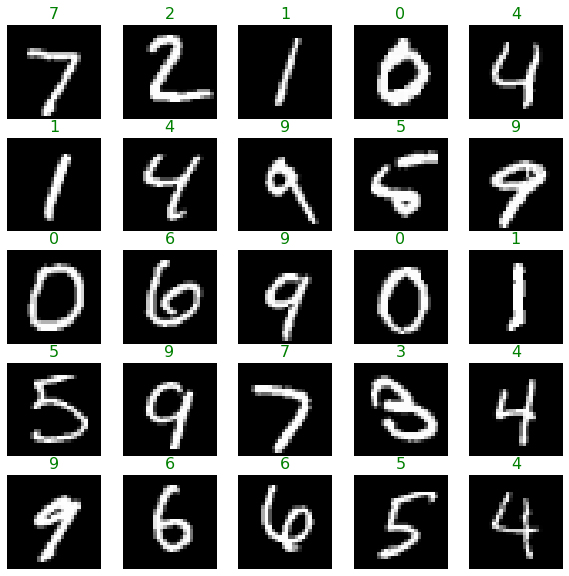

In [30]:
plot_predictions_images(images[:25], labels[:25], pred_labels[:25], rows=5)

### PLot confusion matrix.

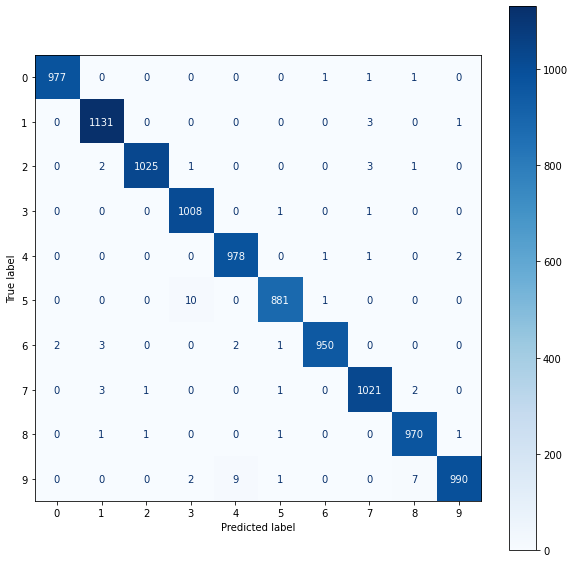

In [31]:
def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

plot_confusion_matrix(labels, pred_labels)

### Model inference

In this section of the notebook we are then going to create a function that predicts what digit is on the image, given an image of a digit. The function will return the following dictionary like object as a prediction response:

```json
{"all": [{"class_name": "zero",
   "label": 0,
   "probability": 5.248521262046779e-08},
  {"class_name": "one", "label": 1, "probability": 1.2809765337351564e-07},
  {"class_name": "two", "label": 2, "probability": 4.821778475161409e-06},
  {"class_name": "three", "label": 3, "probability": 1.6562404425712884e-07},
  {"class_name": "four", "label": 4, "probability": 1.0630603355821222e-05},
  {"class_name": "five", "label": 5, "probability": 5.849686885994743e-07},
  {"class_name": "six", "label": 6, "probability": 7.213602631894744e-11},
  {"class_name": "seven", "label": 7, "probability": 0.9998502731323242},
  {"class_name": "eight", "label": 8, "probability": 3.5614900184555154e-07},
  {"class_name": "nine", "label": 9, "probability": 0.00013307905464898795}],
 "prediction": {"class_name": "seven",
  "label": 7,
  "probability": 0.9998502731323242}}
```

In [56]:
classes = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

In [59]:
def predict_digit(model, device, image):
  model.eval()
  with torch.no_grad():
    image = image.view(-1, 1, 28, 28).to(device)
    predictions = F.softmax(model(image), dim=1)
    top_pred = int(predictions.argmax(1).item())
    predictions = predictions.squeeze().cpu().numpy()

    preds = [{"label": i, "class_name": classes[i], "probability":  float(prob) } for i, prob in enumerate(predictions)]
    return{
        "all":preds,
        "prediction": 
         {"label": top_pred, "class_name": classes[top_pred], "probability":  float(predictions[top_pred]) }
    }

In [60]:
predict_digit(mnist_lenet, device, images[0])

{'all': [{'class_name': 'zero',
   'label': 0,
   'probability': 5.248521262046779e-08},
  {'class_name': 'one', 'label': 1, 'probability': 1.2809765337351564e-07},
  {'class_name': 'two', 'label': 2, 'probability': 4.821778475161409e-06},
  {'class_name': 'three', 'label': 3, 'probability': 1.6562404425712884e-07},
  {'class_name': 'four', 'label': 4, 'probability': 1.0630603355821222e-05},
  {'class_name': 'five', 'label': 5, 'probability': 5.849686885994743e-07},
  {'class_name': 'six', 'label': 6, 'probability': 7.213602631894744e-11},
  {'class_name': 'seven', 'label': 7, 'probability': 0.9998502731323242},
  {'class_name': 'eight', 'label': 8, 'probability': 3.5614900184555154e-07},
  {'class_name': 'nine', 'label': 9, 'probability': 0.00013307905464898795}],
 'prediction': {'class_name': 'seven',
  'label': 7,
  'probability': 0.9998502731323242}}

### Loading the image from local file.



In [61]:
from PIL import Image

In [62]:
def preprocess_img(img):
  """
  takes in a pillow image and pre process it
  """
  preproces_1 =  nn.Sequential(
   transforms.Resize([28,28]),
   transforms.Grayscale(1)
  )
  preprocess_2 =  nn.Sequential(
    transforms.Normalize(mean=[mean], std=[std], inplace=False)
  )
  img = preprocess_2(transforms.ToTensor()(preproces_1(img)))
  return img

In [ ]:
pil_image = Image.open("path_to_image")
img = preprocess_img(pil_image)
img

In [ ]:
predict_digit(mnist_lenet, device, img)

### Downloading the best model

In the following code cell we are going to download and save the model as a static file.

In [33]:
from google.colab import files

files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>